# Simple PINN for an elastic plate with a hole 

## Represent geometry

We represent the geometry by a set of collocation points 

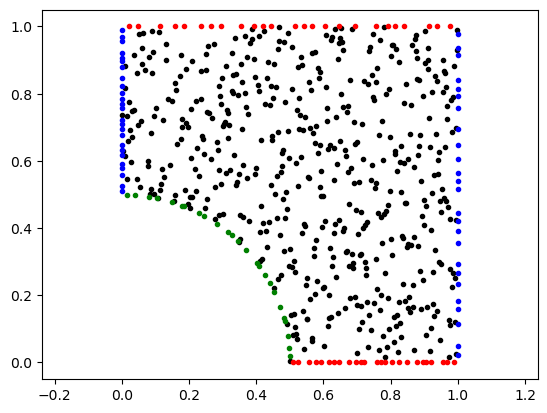

In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from global_constants import L, R, B0, EPS0, MU, LBD


# Create collocation points
N = 25
domain = L * qmc.LatinHypercube(d=2).random(N**2).astype(np.float32)
mask = ((domain[:,0] ** 2 + domain[:,1] ** 2) > R**2)
domain = tf.convert_to_tensor(domain[mask])

# Boundaries
zeros = np.zeros((N,1))
ones = np.ones((N,1))
line = qmc.LatinHypercube(d=1).random(N)
phi = 0.5 * np.pi * qmc.LatinHypercube(d=1).random(N)

top = L * np.hstack((line, ones)).astype(np.float32)
bottom = L * np.hstack((R + (L-R)*line, zeros)).astype(np.float32)
left = L * np.hstack((zeros, R + (L-R)*line)).astype(np.float32)
right = L * np.hstack((ones, line)).astype(np.float32)

hole = np.hstack((R * np.cos(phi), R * np.sin(phi))).astype(np.float32)
hole_nx = -tf.convert_to_tensor((hole[:, 0]) / R)
hole_ny = -tf.convert_to_tensor((hole[:, 1]) / R)
hole_normal = tf.stack([hole_nx, hole_ny], axis=1)

# # Reference solution from FEM
# with open("input.npy", "rb") as file:
#     input = np.load(file).T
# with open("output.npy", "rb") as file:
#     output = np.load(file).T


# Visualize geometry (Dirichlet blue, Neumann red)
plt.plot(*domain.numpy().T, ".k")
plt.plot(*top.T, ".r")
plt.plot(*bottom.T, ".r")
plt.plot(*left.T, ".b")
plt.plot(*right.T, ".b")
plt.plot(*hole.T, ".g")
plt.axis("equal");


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \reals^2 \rightarrow \reals^2$ with five hidden layers having 20 neurons each.

![ann](ann.png)

In [2]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,), name="input"))
for i in range(5):
    model.add(keras.layers.Dense(20, activation="tanh", name=f"hidden-{i}"))
model.add(keras.layers.Dense(2, activation="linear", name="output"))

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the PDE 
$$
    \nabla \cdot \sigma - \mathbf{b} = \mathbf{0}. 
$$

In [3]:
@tf.function
def sigma(eps):
    I = tf.eye(2)
    return 2.0 * MU * eps + LBD * tf.einsum("...ii,...jk->...jk", eps, I)

@tf.function
def epsilon(x, y):
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        disp = model(tf.stack([x, y], axis=1))
        u = disp[:, 0]
        v = disp[:, 1]
    ux = g.gradient(u, x)
    uy = g.gradient(u, y)
    vx = g.gradient(v, x)
    vy = g.gradient(v, y)

    gradx = tf.stack([ux, vx], axis=1)
    grady = tf.stack([uy, vy], axis=1)
    grad = tf.stack([gradx, grady], axis=2)

    return 0.5 * (grad + tf.transpose(grad, perm=[0, 2, 1]))

@tf.function
def pde_residual(x, y):
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        g.watch(y)
        stress = sigma(epsilon(x,y))
        s_xx = stress[:,0,0]
        s_xy = stress[:,0,1]
        s_yy = stress[:,1,1]

    residual_x = g.gradient(s_xx, x) + g.gradient(s_xy, y) - B0
    residual_y = g.gradient(s_xy, x) + g.gradient(s_yy, y)
    return residual_x, residual_y


## The loss function

In [4]:
W_PDE = 0.1
W_NEUMANN = 0.1

def custom_loss(pos):
    def loss(true, prediction):
        # # Loss compared to reference solution
        # ref_error = tf.reduce_mean(tf.square(true-prediction)) 

        # pde
        res_x, res_y = pde_residual(pos[:, 0], pos[:, 1])
        pde_error = tf.reduce_mean(tf.square(res_x)) + tf.reduce_mean(tf.square(res_y))

        # left boundary
        left_error = tf.reduce_mean(tf.square(model(left)[:, 0] - 0.0)) 

        # right boundary
        right_error = tf.reduce_mean(tf.square(model(right)[:, 0] - EPS0 * L)) 

        # bottom boundary
        bottom_error = tf.reduce_mean(tf.square(model(bottom)[:, 1] - 0.0)) 

        # top boundary
        stress_top = sigma(epsilon(top[:, 0], top[:, 1]))
        top_error = tf.reduce_sum(tf.square(stress_top[:, 1, 1])) + tf.reduce_sum(
            tf.square(stress_top[:, 0, 1])
        )

        # hole boundary
        stress_hole = sigma(epsilon(hole[:, 0], hole[:, 1]))
        traction = tf.einsum("...ij,...j->...i", stress_hole, hole_normal)
        hole_error = tf.reduce_sum(tf.square(traction[:, 0])) + tf.reduce_sum(
            tf.square(traction[:, 1])
        )

        return (
            left_error
            + right_error
            + bottom_error
            + W_NEUMANN * top_error
            + W_NEUMANN * hole_error
            + W_PDE * pde_error
        )
    return loss


## Training 

2023-02-10 14:56:52.549389: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


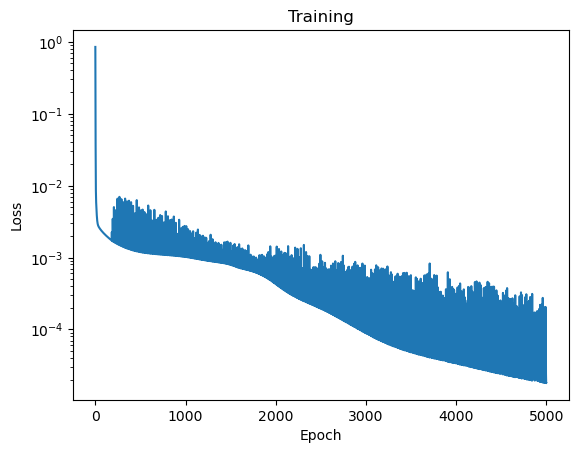

In [5]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=custom_loss(domain))

dummy = np.zeros_like(domain)
history = model.fit(dummy, dummy, epochs=5000, verbose=0)

plt.semilogy(history.history["loss"])
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


## Visualization of results

63/63 [==============================] - 0s 438us/step


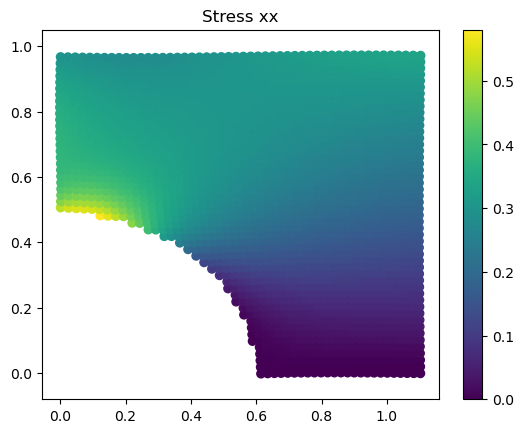

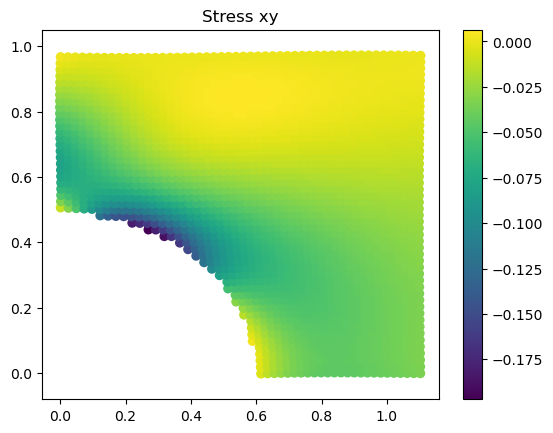

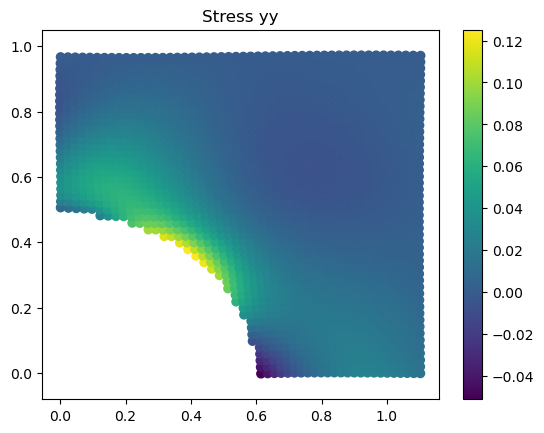

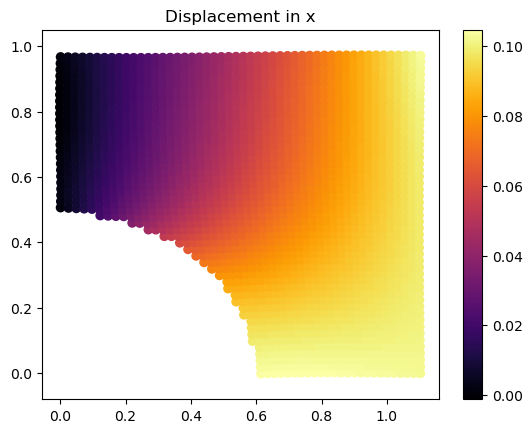

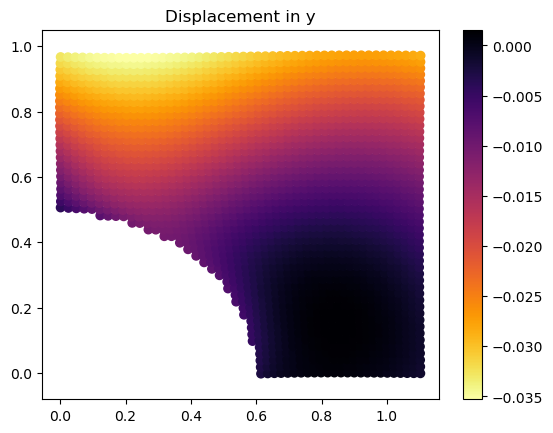

In [6]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.astype(np.float32).ravel(), val_y.astype(np.float32).ravel()]).T
mask = ((val_domain[:,0] ** 2 + val_domain[:,1] ** 2) > R**2)
val_domain = val_domain[mask]

# Compute model predictions on the validation domain
disp = model.predict(val_domain)
def_val_domain = val_domain + disp
strain = epsilon(*val_domain.T)
stress = sigma(strain)

plt.scatter(*def_val_domain.T, c=stress[:, 0, 0], vmin=0)
plt.axis("equal")
plt.colorbar()
plt.title("Stress xx")
plt.show()

plt.scatter(*def_val_domain.T, c=stress[:, 0, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress xy")
plt.show()

plt.scatter(*def_val_domain.T, c=stress[:, 1, 1])
plt.axis("equal")
plt.colorbar()
plt.title("Stress yy")
plt.show()

plt.scatter(*def_val_domain.T, c=disp[:, 0], cmap="inferno")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in x")
plt.show()

plt.scatter(*def_val_domain.T, c=disp[:, 1], cmap="inferno_r")
plt.axis("equal")
plt.colorbar()
plt.title("Displacement in y")
plt.show()

